In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import time

import yfinance as yf

In [2]:

from numpy.linalg import det, inv, eigvalsh
from sklearn.covariance import LedoitWolf

from scipy.optimize import minimize, LinearConstraint, Bounds, basinhopping

import matplotlib.pyplot as plt

## YFinance Data Fetch

In [3]:
# Yfinance method to find the most traded stocks
# List of stock tickers
stocks =["AAPL", "MSFT", "AMZN", "FB", "GOOGL", "BRK-B", "JNJ",
"WMT", "V", "PG", "NVDA", "JPM", "UNH", "HD", "MA", "DIS", "PFE", "VZ", 
"INTC", "CMCSA", "T", "KO", "MRK", "PEP", "ABT", "CVX", "ORCL", "CSCO", 
"NFLX", "XOM", "IBM", "NKE", "CRM", "ADBE", "AVGO", "GS", "QCOM", "BA", 
"PYPL", "TXN", "AXP", "AMD", "C", "MS", "CAT", "HON", "SBUX", "COST", "MCD"] 
# 

# Start and end dates
start_date = '1999-01-01'
end_date = '2007-12-31'

# Downloading data for all stocks at once
data = yf.download(tickers = stocks, start=start_date, end=end_date,
                   auto_adjust = False)['Adj Close']

data

[*********************100%***********************]  49 of 49 completed

4 Failed downloads:
['AVGO', 'PYPL', 'V']: YFPricesMissingError('possibly delisted; no price data found  (1d 1999-01-01 -> 2007-12-31) (Yahoo error = "Data doesn\'t exist for startDate = 915166800, endDate = 1199077200")')
['FB']: YFTzMissingError('possibly delisted; no timezone found')


Ticker,AAPL,ABT,ADBE,AMD,AMZN,AVGO,AXP,BA,BRK-B,C,...,PYPL,QCOM,SBUX,T,TXN,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
1999-01-04,0.310341,11.263657,6.183796,14.00000,2.957813,NaN,20.813614,20.981510,46.599998,131.575424,...,NaN,2.182585,2.567492,7.052632,13.524843,4.480468,NaN,13.587291,8.577147,16.089714
1999-01-05,0.325857,11.278095,6.052225,13.84375,3.112500,NaN,20.416302,22.454609,45.540001,134.027100,...,NaN,2.249023,2.478136,7.052632,13.825610,4.554628,NaN,14.388468,8.643638,15.951247
1999-01-06,0.314102,11.191448,5.835519,13.62500,3.450000,NaN,21.297495,22.972176,45.139999,142.199554,...,NaN,2.340066,2.457285,7.279390,14.233091,4.746207,NaN,14.720416,8.789917,16.588198
1999-01-07,0.338553,11.047046,5.959351,13.71875,3.971875,NaN,21.554401,22.812922,44.080002,152.987030,...,NaN,2.359751,2.466221,7.532148,14.203992,4.665866,NaN,14.753343,8.949495,16.560503
1999-01-08,0.338553,11.003726,6.044485,14.00000,4.006250,NaN,22.209507,22.812922,43.500000,151.516083,...,NaN,2.372054,2.519835,7.776479,14.553274,4.499009,NaN,14.917996,8.882997,16.463573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007-12-21,5.835450,18.740498,42.180000,7.79000,4.563000,NaN,39.455227,65.277138,89.500000,214.766754,...,NaN,26.344095,8.029161,8.731974,21.749031,46.842976,NaN,16.881519,11.131674,50.404552
2007-12-24,5.982606,18.769432,42.840000,7.77000,4.550500,NaN,40.434956,65.973389,90.800003,220.022293,...,NaN,26.574842,8.090158,8.736186,21.954937,46.755623,NaN,17.060539,11.254052,50.528648
2007-12-26,5.987121,18.618256,43.119999,7.77000,4.642500,NaN,40.176727,65.958733,91.400002,216.258163,...,NaN,26.555056,7.937658,8.904596,21.942068,46.811192,NaN,17.178623,11.170925,51.149067


In [4]:
# 'CRM', 'FB', 'GOOGL', 'MA' have null values

bad_data = ['AVGO', 'PYPL', 'V', 'CRM', 'FB', 'GOOGL', 'MA']

data = data.drop(columns = bad_data)


In [5]:
#training and testing dates

training_period_start = "1999-01-01"
training_period_end = "2007-12-31"
test_period_end = "2008-12-31"


In [6]:
daily_returns = data.pct_change(fill_method='ffill')

C:\Users\prith\AppData\Local\Temp\ipykernel_49528\4103529606.py:1: FutureWarning: The 'fill_method' keyword being not None and the 'limit' keyword in DataFrame.pct_change are deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change(fill_method='ffill')


In [7]:
gamma = 1
n = daily_returns.shape[1]
#one = np.full(n, 1) 

#  Calculate the mean and covariance of daily returns for the first 12 years
h_data = daily_returns.loc[training_period_start:training_period_end].iloc[1:]
h_data.fillna(0, inplace=True)

mu = np.array(h_data.mean())


In [8]:
#h_data
nan_counts = h_data.isnull().sum()

# Print the result
print(nan_counts[nan_counts!=0])

Series([], dtype: int64)


In [9]:
lw = LedoitWolf(store_precision=True, assume_centered=False)
lw.fit(h_data)  

# 2. Extract the shrunk covariance and its inverse (the precision matrix)
Sigma_shrunk   = lw.covariance_    # shape (n, n)
inv_Sigma_shrunk = lw.precision_ 

## Nominal Case

In [10]:
def portfolio_performance(a, mu, Sigma, gamma):
    return -a.T @ mu + (gamma / 2) * a.T @ Sigma @ a

# Function to calculate worst-case covariance matrix
def worst_case_covariance_matrix(Sigma, theta, gamma, a):
    inv_Sigma_wc = inv(Sigma) - theta * gamma * np.outer(a, a)
    return inv(inv_Sigma_wc)

In [11]:
a_hat = (1/gamma)* inv_Sigma_shrunk @ mu
print("Optimal Weights", a_hat)

Optimal Weights [ 1.52466211  0.59992834  0.58763866 -0.3622643   0.27858561 -0.35508689
  1.00010792  1.36879049 -0.31751311  0.72927697 -0.48092477  0.50783394
 -0.78332388  1.10452408 -0.4929021   1.09330445 -1.55718369 -0.5533987
 -0.71112867 -1.20685873  1.20776942 -0.891659   -1.15527919  0.24161287
 -0.00844535 -0.15281125 -0.76188261  0.77795357  1.0348689   1.07248241
  0.37808529  1.35079456 -1.95343098  1.1636204   0.96164813  0.22056854
 -0.33649356 -0.04069707  2.30587221  0.17813511  0.00785889  0.95358132]


In [12]:
performance_nominal = portfolio_performance(a_hat, mu, Sigma_shrunk, gamma)
print("Performance in Nominal Model:", performance_nominal)

theta1 = 0.2
# Calculate worst-case covariance matrix
Sigma_tilda = worst_case_covariance_matrix(Sigma_shrunk, theta1, gamma, a_hat)

# Calculate performance in the worst-case model
performance_wc = portfolio_performance(a_hat, mu, Sigma_tilda, gamma)
print("Performance in Worst-Case Model:", performance_wc)

Performance in Nominal Model: -0.008173350444845823
Performance in Worst-Case Model: -0.008146541333744057


## Worst Case Portfolio

In [13]:
I = np.eye(n)

#speciific case for analysis
theta_ = 0.2

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma_shrunk))
    return (1/theta)*np.log(term1) - a.T @ mu

def positive_definite_constraint(a, theta):
    eigen_min = eigvalsh(inv_Sigma_shrunk - theta * gamma * np.outer(a,a) )
    return eigen_min - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [14]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, np.inf)

# Set the constraint that the sum of weights equals 1.
initial_weights = np.ones(n) / n

# Define constraints in the format required by 'minimize'
constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}

# Perform the optimization
result = minimize(objective_a_oftheta, initial_weights, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [ 1.69966083  0.43141133  0.72064096 -0.40872177  0.30083209 -0.13372858
  0.81907832  0.71233705 -0.2805227   0.83749233 -0.53228824  0.24922675
 -1.02094598  0.89709987 -0.43991076  0.467205   -1.01063205 -0.17860848
 -0.57538522 -1.14338228  0.57386191 -0.60331827 -0.15187736  0.30506935
 -0.06614018 -0.16608761 -0.77912975  0.76406104  0.9900833   0.8795745
  0.3142051   0.776207   -0.83410049  0.80499487  1.14805695  0.44836217
 -0.11032581 -0.29949381  2.26484261 -0.07239595 -0.171574    0.83287207]
 Minimum adjective reached at -0.0076022326358831304 Not portfolio objective!


In [15]:
#computaion of entropy, risk_measurement
#mvo = mean variance objective

Rel_entropy = 0.5*(np.log(det(Sigma_shrunk @ inv(Sigma_tilda) )) + np.trace(inv_Sigma_shrunk @ Sigma_tilda - I))

RPs_nominal = portfolio_performance(a_star, mu, Sigma_shrunk, gamma)

RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)
RPs_worstcase2 = portfolio_performance(a_star, mu, Sigma_tilda, gamma)
# Both of them are the same

print('RPs_nominal ', RPs_nominal)
print('RPs_worstcase ', RPs_worstcase2)
print('Rel_entropy ', Rel_entropy)

RPs_nominal  -0.007613834907909167
RPs_worstcase  -0.007590586080807367
Rel_entropy  2.683837500851941e-06


In [24]:
results_ = {}
#thetas = (np.exp(np.linspace(0, 5, 100)) - 1)[1:]
thetas = (np.linspace(10, 900, 90)) 
for theta_ in thetas:
    # Initial guess for 'a'
    a0 = np.ones(n)/n
    
    # Define constraints in the format required by 'minimize'
    constraints = {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)}
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk_measurement
    #mvo = mean variance objective
    Sigma_tilda = inv(inv_Sigma_shrunk - theta_ * gamma * np.outer(a_star, a_star))
    
    Rel_entropy = (np.log(det(Sigma_shrunk @ inv(Sigma_tilda) )) + np.trace(inv_Sigma_shrunk @ Sigma_tilda - I))/2
    
    RPs_nominal = portfolio_performance(a_star, mu, Sigma_shrunk, gamma)
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

    results_[theta_] = (Rel_entropy, NPs_worstcase, RPs_nominal, RPs_worstcase)

C:\Users\prith\AppData\Local\Temp\ipykernel_49528\362602952.py:7: RuntimeWarning: invalid value encountered in sqrt
  term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma_shrunk))


In [25]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'NPs_worstcase', 'RPs_nominal',  'RPs_worstcase'])

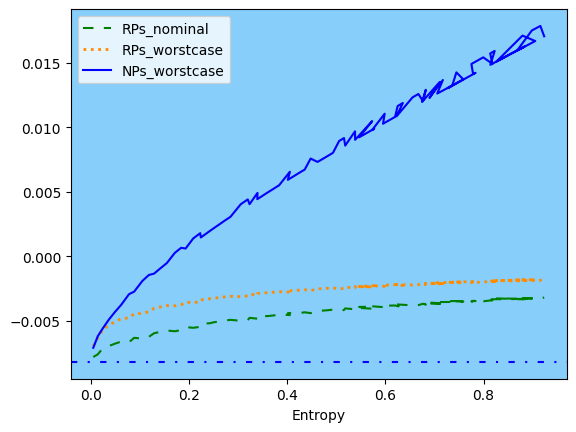

In [26]:
# No bounds no linear constraints just simple results
fig = plt.figure()
#fig.patch.set_facecolor('lightskyblue')
ax = plt.gca()
ax.set_facecolor('lightskyblue')
ax.axhline(y = performance_nominal, color = 'b', linestyle = (0, (3, 5, 1, 5)))  # NP Nominal
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green') # RP Nominal

df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=2, color='darkorange') # RP Robust
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue') # NP Robust

plt.show()

# Only Variance as the risk measure

In [54]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
ones_for_sum = np.ones((1, n))
linear_constraint = LinearConstraint(ones_for_sum, [1], [1])

initial_weights = np.ones(n) / n


def objective_nom(a, Sigma): #calculate portfolio risk
    return (gamma/2)*np.dot(a, np.dot(a, Sigma))- np.dot(a, mu)

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(objective_nom, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds, args = (Sigma))
a_hat = res.x
print("Optimal Weights:", a_hat)

# The corresponding relative entropy with this is zero, because we haven't changed the distribution
E_Va = np.dot(a_hat, np.dot(a_hat, Sigma))
E_Va

Optimal Weights: [0.00199756 0.33564616 0.00138443 0.00110532 0.00093934 0.00116467
 0.57887675 0.00088427 0.07512309 0.00287842]


0.0008986857677069074

In [56]:
results_ = {}
thetas = (np.exp(np.linspace(0, 6)) - 1)[1:]
for theta in thetas:
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta)
    first_positive = np.argmax(min_eig_vals > 0)
    a0 = points_on_hyperplane[first_positive]

    constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta,)},
    linear_constraint
    ]
    
    # Setting up the minimizer_kwargs for basinhopping
    minimizer_kwargs = {"method": 'SLSQP',
                        "bounds": bounds,
                        "constraints": constraints,
                        "args": (theta,)}
    
    # Perform the basinhopping optimization
    result = basinhopping(objective_a_oftheta, a0, minimizer_kwargs=minimizer_kwargs)

    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk-measurement
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = np.dot(a_star, np.dot(a_star, Sigma))
                    
    NP_worstcase = np.dot(a_hat, np.dot(a_hat, Sigma_tilda))
    RPs_worstcase = np.dot(a_star, np.dot(a_star, Sigma_tilda))
    
    results_[theta] = (entropy, RPs_nominal, NP_worstcase, RPs_worstcase)

Optimized a: [2.31474537e-02 4.13448905e-01 4.23912755e-02 6.72205347e-18
 0.00000000e+00 1.51788304e-17 3.89965314e-01 6.50521303e-19
 1.31047052e-01 0.00000000e+00]
 Minimum adjective reached at -0.0006323958151871879 Not portfolio objective!
Optimized a: [2.77555756e-17 4.43655333e-01 0.00000000e+00 3.46944695e-17
 2.08166817e-17 1.08272958e-02 4.80303077e-01 1.73472348e-18
 6.52142943e-02 0.00000000e+00]
 Minimum adjective reached at -0.0006472380816865099 Not portfolio objective!
Optimized a: [0.00000000e+00 4.60079327e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.14489709e-01 5.55111512e-17
 1.25430964e-01 0.00000000e+00]
 Minimum adjective reached at -0.0006400382786122016 Not portfolio objective!
Optimized a: [0.00000000e+00 2.97376823e-01 1.42341657e-02 0.00000000e+00
 6.93889390e-18 0.00000000e+00 6.14372561e-01 0.00000000e+00
 7.40164504e-02 2.77555756e-17]
 Minimum adjective reached at -0.0006581731737518348 Not portfolio objective!
Optimized a: [6.9388

In [57]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'RPs_nominal', 'NPs_worstcase', 'RPs_worstcase'])

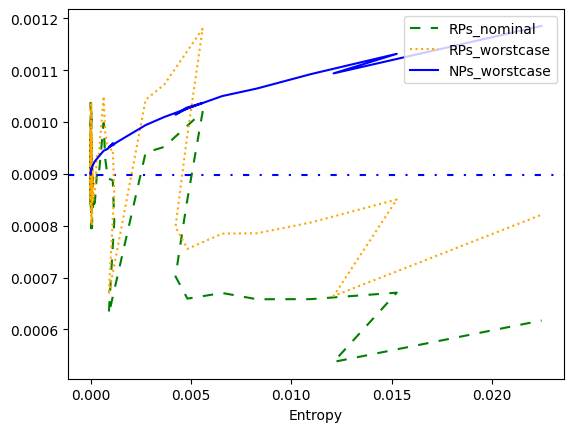

In [58]:
ax = plt.gca()
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green')
ax.axhline(y = E_Va, color = 'b', linestyle = (0, (3, 5, 1, 5)))
df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=1.5, color='orange')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()